# Classification Network

The goal here is to classify whether the error rate is "low" "medium" or "high".
If we can successfully do this, then look at whether we can get the sign right. Start off by using the squeezenet model.

### Todos:
- [x] Add dense layer
- [x] Abstract images file
- [ ] Write a models.py 
- [ ] high resolution flow
- [ ] try adding flow and raw images


In [1]:
## Setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


Loading vector data
Loading image data
Preprocessing data
Input shape:  (9400, 48, 64, 2)


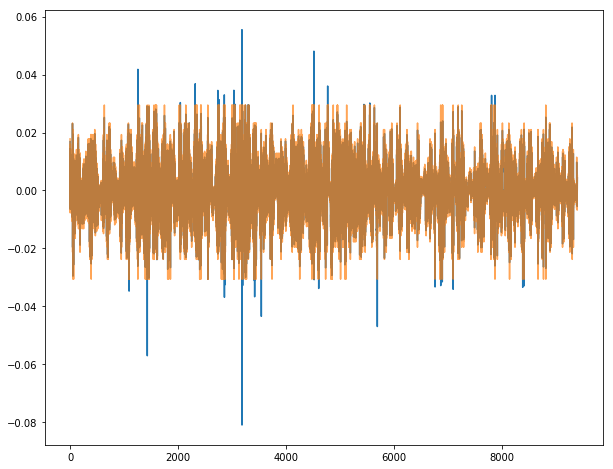

In [28]:
BATCH_SIZE = 64
NUM_CLASSES = 128
TRAIN_RATIO = 0.6

import utilities
# Datafile options:
imu_data,x_data,y_norm = utilities.load_data('flows_lowres_16k.npy')
#imu_data,flows_data,y_norm = utilities.load_data('../gbucket/center_cropped_300x300.npy')
#imu_data,x_data,y_norm = utilities.load_data('../gbucket/center_cropped_192x192.npy')

# Split into training/val data:
N_training = int(TRAIN_RATIO*x_data.shape[0])
N_validation = x_data.shape[0]- N_training

y_data, mean_vals = utilities.discretize_outputs(y_norm[0:N_training], NUM_CLASSES)
y_data, tmp = utilities.discretize_outputs(y_norm, NUM_CLASSES)

x_train = x_data[0:N_training,...]
y_train = y_data[0:N_training]

x_val = x_data[N_training:,...]
y_val = y_data[N_training:]

print('Input shape: ', x_data.shape)

# Plot the discretization with perfect classification:
plt.plot(y_norm)
plt.plot(mean_vals[y_data.astype(np.int32)],alpha=0.7)



In [30]:
from classifiers.squeezenet import SqueezeNet

tf.reset_default_graph() # remove all existing variables in the graph 
sess = get_session() # start a new Session

# Load the model:
model = SqueezeNet(NUM_CLASSES, x_data.shape[3], x_data.shape[1])
# If you want a pretrained model, pass save_path as an argument. 
# Since pretrained weights didn't do well, let's skip them. 
# SAVE_PATH = 'classifiers/squeezenet.ckpt'

# Slow way to initialize variables that is robust to partially loaded models:
uninitialized_vars = []
for var in tf.global_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)
        
init = tf.variables_initializer(uninitialized_vars)
sess.run(init)



(9400, 48, 64, 2)
Step:  10  Train:  0.0155004987832  Val:  0.0344828 loss 0.00955748850411 LR:  0.00019800000000000002


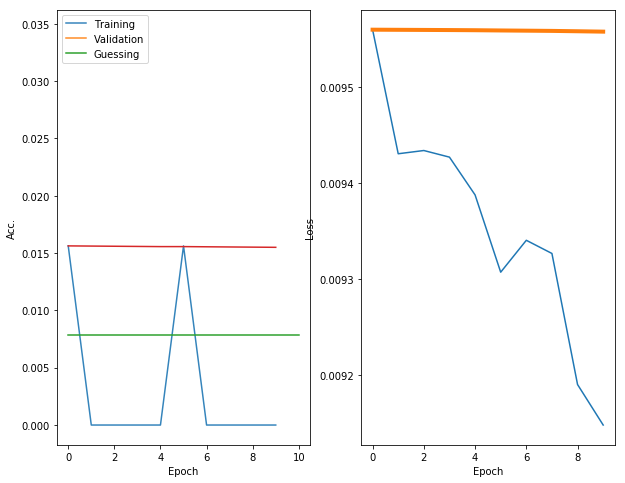

plotting from  0  to  9400
High correlation (near 1) means we are predicting well.
Correlation between error and signal: 0.000167843997431


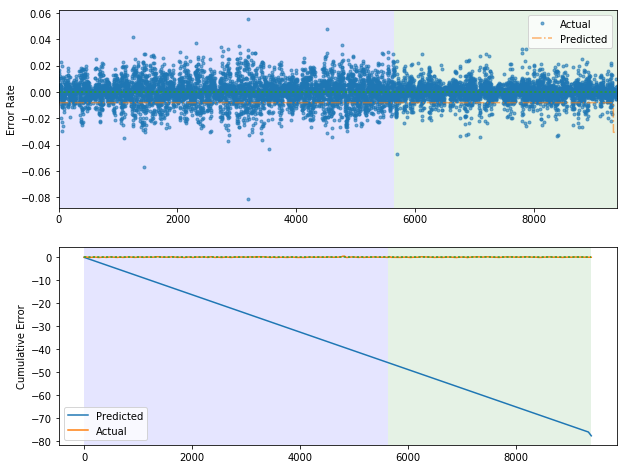

Step:  20  Train:  0.0154084089283  Val:  0.0 loss 0.00955245566078 LR:  0.00019800000000000002


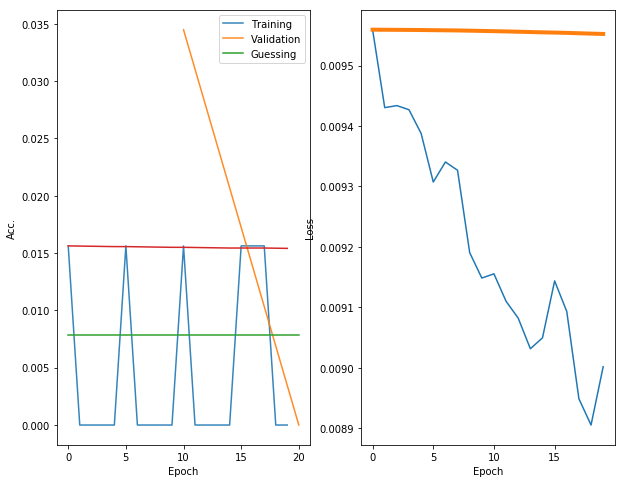

plotting from  0  to  9400
High correlation (near 1) means we are predicting well.
Correlation between error and signal: 0.000167843997431


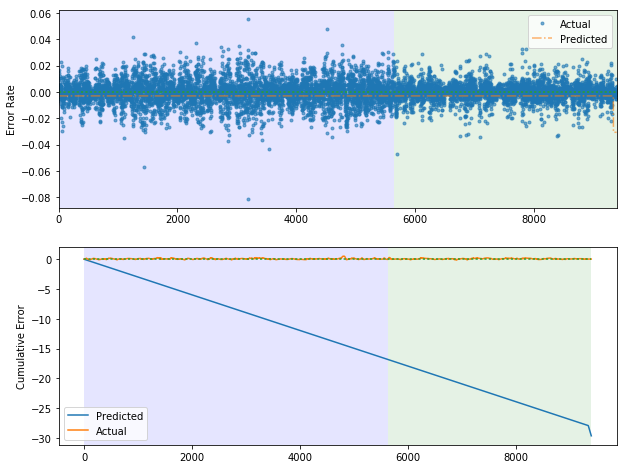

Step:  30  Train:  0.0153087554854  Val:  0.0 loss 0.00954583348668 LR:  0.00019800000000000002


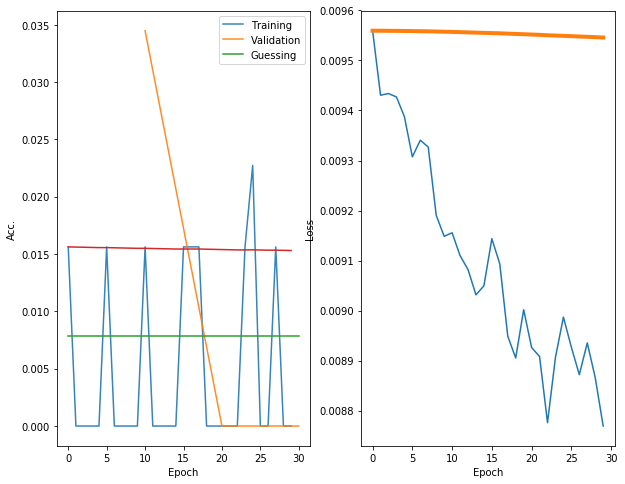

In [ ]:
print(x_data.shape)
# simple parameters:
disp_period = 10
training_iters = 1000
lr = 0.0002 # 0.0002 is a good value for 20 bins
lr_decay=0.99

# Launch the graph
step = 1 
history = {'train_acc': [], 'train_loss': [], 's_tacc': [], 's_tloss': [], 'val_inds': [], 'val_acc':[]}
smooth_val = 0.999

for step in range(training_iters):
    if step % 30 is 0:
        lr *= lr_decay
    batch_x, batch_y = utilities.sample_seqbatch(BATCH_SIZE, 1, x_train, y_train)
    o,loss,acc = sess.run([model.optimizer,model.loss, model.acc], feed_dict={model.image: batch_x, model.labels: batch_y, model.lr:[lr]})

    history["train_acc"].append(acc)
    history["train_loss"].append(loss)
    if(step is 0):
        history["s_tloss"].append(loss)
        history["s_tacc"].append(acc)
    else:
        history["s_tloss"].append(smooth_val*history["s_tloss"][-1] + (1-smooth_val)*loss)
        history["s_tacc"].append(smooth_val*history["s_tacc"][-1] + (1-smooth_val)*acc)

    step += 1
    if step % disp_period is 0:
        # Calculate val accuracy:
        batch_x, batch_y = utilities.sample_seqbatch(BATCH_SIZE, 1, x_val, y_val)
        acc_v = sess.run(model.acc, feed_dict={model.image: batch_x, model.labels: batch_y})
        history["val_acc"].append(acc_v)
        history["val_inds"].append(step)

        print('Step: ', step, ' Train: ', history["s_tacc"][-1], ' Val: ', history["val_acc"][-1], 'loss', history["s_tloss"][-1], 'LR: ', lr)
        plt.subplot(1,2,1)
        plt.plot(history["train_acc"],alpha=0.9)
        plt.plot(history["val_inds"], history["val_acc"],alpha=0.9)
        plt.plot([0,step], [1/NUM_CLASSES,1/NUM_CLASSES])
        plt.legend(['Training','Validation','Guessing'])
        plt.plot(history["s_tacc"])
        plt.xlabel('Epoch')
        plt.ylabel('Acc.')
        plt.subplot(1,2,2)
        plt.plot(history["train_loss"])
        plt.plot(history["s_tloss"], linewidth=4)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

        # Prediction is cheap for this:
        y_pred = np.zeros_like(y_data)
        for k in range(0,x_data.shape[0]-(x_data.shape[0]%BATCH_SIZE),BATCH_SIZE):
            imgs = x_data[k:k+BATCH_SIZE,:,:]
            pred = sess.run(model.prediction, feed_dict={model.image: imgs, model.labels: y_norm[k:k+BATCH_SIZE]})
            y_pred[k:k+BATCH_SIZE] = pred
        prediction = mean_vals[(y_pred).astype(np.int32)];
        
        utilities.plot_data(0,y_data.shape[0], prediction, y_norm, x_train.shape[0])


    # Compute sequence prediction:
print('Done.')


In [24]:
# Load data
# Import chelsea's data
# Check times versus times.csv
# [t, x_tango, y_tango, z_tango, x_vicon, y_vicon, z_vicon, x_err_rate, y_err_rate, z_err_rate]
# Error rates, xyz
print('Loading data...')
d_raw = (np.genfromtxt('trasnformed_data_slash_2.csv',delimiter=',')).astype(np.float32)
t_raw = d_raw[:,0]
t_img = (np.genfromtxt('rates.csv',delimiter=',')[:,0]).astype(np.float32)

## Align start of data streams
i_start = 0
for k in range(t_img.shape[0]):
    if(t_img[k]>t_raw[0]):
        i_start = k
        break
if i_start is 0:
    print('Warning! Time sequence alignment failed!')

# Extract and interpolate data
t_img = t_img[i_start:]
imu_data = (np.genfromtxt('rates.csv', delimiter=',')[i_start:,1:7]).astype(np.float32)
y_data = np.array([np.interp(t_img, t_raw, d_raw[:,7]), np.interp(t_img, t_raw, d_raw[:,8]), np.interp(t_img, t_raw, d_raw[:,9])]).T


pos_err = np.zeros(d_raw.shape[0])
for k in range(d_raw.shape[0]):
    pos_err[k] = np.linalg.norm(d_raw[k,1:4]-d_raw[k,4:7])
pos_err_rate = np.diff(pos_err);

# Should really automate this... or just re-save file.
flows_data = np.load('../gbucket/center_cropped_300x300.npy').astype(np.float32)
#flows_data = []
#flows_data.append(np.load('flows_lowres_1_16.npy'))
#flows_data.append(np.load('flows_lowres_2_16.npy'))
#flows_data.append(np.load('flows_lowres_3_16.npy'))
#flows_data.append(np.load('flows_lowres_4_16.npy'))
#flows_data.append(np.load('flows_lowres_5_16.npy'))
#flows_data.append(np.load('flows_lowres_6_16.npy'))
#flows_data.append(np.load('flows_lowres_7_16.npy'))
#flows_data.append(np.load('flows_lowres_8_16.npy'))
#flows_data.append(np.load('flows_lowres_9_16.npy'))
#flows_data.append(np.load('flows_lowres_10_16.npy'))
#flows_data.append(np.load('flows_lowres_11_16.npy'))
#flows_data.append(np.load('flows_lowres_12_16.npy'))
#flows_data.append(np.load('flows_lowres_13_16.npy'))
#flows_data.append(np.load('flows_lowres_14_16.npy'))
#flows_data.append(np.load('flows_lowres_15_16.npy'))
#flows_data.append(np.load('flows_lowres_16_16.npy'))
#flows_data = np.concatenate(flows_data,axis=0)
flows_data = flows_data[i_start:,:,:]


print('Pre-processing data...')
# Shorten datastream:
i_start = 600 # remove initial weird-ness
i_end = flows_data.shape[0]
y_raw = y_data[i_start:i_end,:]
imu_data = imu_data[i_start:i_end,:]
flows_data = flows_data[i_start:i_end,:,:]

pos_err = pos_err[i_start:i_end]
pos_err_rate = pos_err_rate[i_start:i_end]

# Get sign from cumulative error:
y_cumulative = np.cumsum(y_data,axis=0)

# Convert y_data into classes:
y_norm = np.zeros(y_raw.shape[0]);
y_norm_c = np.zeros(y_raw.shape[0]+1);
for k in range(y_raw.shape[0]):
    y_norm[k]=np.linalg.norm(y_raw[k,:])
    y_norm_c[k+1] = np.linalg.norm(y_cumulative[k,:])

    

y_norm = pos_err_rate

minval = np.min(y_norm)
maxval = np.max(y_norm)


NUM_CLASSES = 128
import utilities
y_data, mean_vals = utilities.discretize_outputs(y_norm, NUM_CLASSES)


# Normalize imu data:
imu_data = imu_data - imu_data.mean(axis=0)
imu_data /= np.std(imu_data,axis=0)

# Normalize image data
flows_data -= flows_data.mean(axis=0)
flows_data /= np.std(flows_data,axis=0)

print('Organizing train/val split...')
N_training = int(0.6*flows_data.shape[0])
N_validation = flows_data.shape[0] - N_training
#training_data_indices = np.random.choice(np.arange(flows_data.shape[0]), N_training)
#validation_data_indices = np.setdiff1d(np.arange(flows_data.shape[0]), training_data_indices)

training_data_indices = np.arange(0,N_training,1,dtype=np.int32)
validation_data_indices = N_training+np.arange(0, flows_data.shape[0]-N_training,1,dtype=np.int32)
tmp, mean_vals = utilities.discretize_outputs(y_norm[training_data_indices], NUM_CLASSES)

print(training_data_indices.shape)
print(N_validation)

# sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
# These need to be randomized more - getting unwanted structure in the train/val split
def sample_minibatch(batch_size, train=True,iseq=None):
    x_img_batch = np.zeros((batch_size, flows_data.shape[1], flows_data.shape[2],1))
    y_batch = np.zeros(batch_size)
    
    if(iseq is None):
        # randomly sample endpoint:
        # choose which subsequence to sample from: 
        if(train):
            i_vals = training_data_indices[np.random.randint(0,N_training,batch_size)]
        else:
            i_vals = validation_data_indices[np.random.randint(0,N_validation,batch_size)]
            i_stop = 0
    else:
        i_vals = i_seq
    y_batch = y_data[i_vals]
    x_img_batch = flows_data[i_vals,:,:].reshape((batch_size, flows_data.shape[1], flows_data.shape[2],1))
    return x_img_batch, y_batch

def calc_rmse(predictions, targets):
    
    return np.sqrt(((predictions.reshape([-1]) - targets.reshape([-1])) ** 2).mean())
if False:
    print('Visualizing data...')
    print('Training vs. Validation sets:')
    plt.subplot(1,2,1)
    plt.plot(imu_data)
    plt.subplot(1,2,2)
    plt.plot(y_norm)
    #p = plt.axhspan(0.25, 0.75, facecolor='0.5', alpha=0.5)
    plt.show()

    plt.subplot(1,2,1)
    plt.plot(y_norm_c)
    plt.show()

    plt.subplot(1,2,1)
    plt.hist(y_data[training_data_indices])
    plt.title('Histogram of classes in training')
    plt.subplot(1,2,2)
    plt.hist(y_data[validation_data_indices])
    plt.title('Histogram of classes in validation')
    plt.show()

Loading data...
Pre-processing data...
Organizing train/val split...
(6756,)
4505


/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in true_divide


In [37]:
BATCH_SIZE = 64

def fire_module(x,inp,sp,e11p,e33p):
    with tf.variable_scope("fire"):
        with tf.variable_scope("squeeze"):
            W = tf.get_variable("weights",shape=[1,1,inp,sp])
            b = tf.get_variable("bias",shape=[sp])
            s = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")+b
            s = tf.nn.relu(s)
        with tf.variable_scope("e11"):
            W = tf.get_variable("weights",shape=[1,1,sp,e11p])
            b = tf.get_variable("bias",shape=[e11p])
            e11 = tf.nn.conv2d(s,W,[1,1,1,1],"VALID")+b
            e11 = tf.nn.relu(e11)
        with tf.variable_scope("e33"):
            W = tf.get_variable("weights",shape=[3,3,sp,e33p])
            b = tf.get_variable("bias",shape=[e33p])
            e33 = tf.nn.conv2d(s,W,[1,1,1,1],"SAME")+b
            e33 = tf.nn.relu(e33)
        return tf.concat([e11,e33],3)

    # input is a factor of 3 skinnier and 4 shorter than expected. So pool less by a factor of 3 and 4?
    # 13x13
    # 4x3

class SqueezeNet(object):
    def extract_features(self, input=None, reuse=True):
        if input is None:
            input = self.image
        x = input
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('layer0'):
                W = tf.get_variable("weights",shape=[3,3,1,64])
                b = tf.get_variable("bias",shape=[64])
                x = tf.nn.conv2d(x,W,[1,2,2,1],"VALID")
                x = tf.nn.bias_add(x,b)
                layers.append(x)
            with tf.variable_scope('layer1'):
                x = tf.nn.relu(x)
                layers.append(x)
            with tf.variable_scope('layer2'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer3'):
                x = fire_module(x,64,16,64,64)
                layers.append(x)
            with tf.variable_scope('layer4'):
                x = fire_module(x,128,16,64,64)
                layers.append(x)
            with tf.variable_scope('layer5'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer6'):
                x = fire_module(x,128,32,128,128)
                layers.append(x)
            with tf.variable_scope('layer7'):
                x = fire_module(x,256,32,128,128)
                layers.append(x)
            with tf.variable_scope('layer8'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer9'):
                x = fire_module(x,256,48,192,192)
                layers.append(x)
            with tf.variable_scope('layer10'):
                x = fire_module(x,384,48,192,192)
                layers.append(x)
            with tf.variable_scope('layer11'):
                x = fire_module(x,384,64,256,256)
                layers.append(x)
            with tf.variable_scope('layer12'):
                x = fire_module(x,512,64,256,256)
                layers.append(x)
        return layers

    def __init__(self, save_path=None, sess=None):
        """Create a SqueezeNet model.
        Inputs:
        - save_path: path to TensorFlow checkpoint
        - sess: TensorFlow session
        """
        self.image = tf.placeholder('float',shape=[None,None,None,1],name='input_image')
        self.labels = tf.placeholder('int32', shape=[None], name='labels')
        self.lr = tf.placeholder('float',shape=[1],name='lr')
        self.layers = []
        x = self.image
        self.layers = self.extract_features(x, reuse=False)
        self.features = self.layers[-1]
        with tf.variable_scope('classifier'):
            with tf.variable_scope('layer0'):
                x = self.features
                self.layers.append(x)
            with tf.variable_scope('layer1'):
                W = tf.get_variable("weights",shape=[1,1,512,1000])
                b = tf.get_variable("bias",shape=[1000])
                x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
                x = tf.nn.bias_add(x,b)
                self.layers.append(x)
            with tf.variable_scope('layer2'):
                x = tf.nn.relu(x)
                self.layers.append(x)
            with tf.variable_scope('layer3'):
                x = tf.nn.avg_pool(x,[1,6,5,1],strides=[1,4,4,1],padding='VALID')
                self.layers.append(x)
# NOT really squeezenet, but ...
            with tf.variable_scope('layer4'):
                x = tf.layers.dense(x, NUM_CLASSES)
                self.layers.append(x)
        print(x.get_shape())
        self.classifier = tf.reshape(x,[BATCH_SIZE, NUM_CLASSES])

        if save_path is not None:
            saver = tf.train.Saver()
#            saver = tf.train.import_meta_graph(save_path*'.meta')
            saver.restore(sess, save_path)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.labels, NUM_CLASSES), logits=self.classifier))
        self.prediction = tf.cast(tf.argmax(self.classifier,1),'int32')
        self.acc = tf.reduce_mean(tf.cast(tf.equal(self.prediction, self.labels),tf.float32))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr[0]).minimize(self.loss)


In [42]:

# Blue background corresponds to data used during training
def plot_data(ns, ne, save=False):    

    print('plotting from ', ns, ' to ', ne)
    
    print('High correlation (near 1) means we are predicting well.')
    m1 = y_norm[ns:ne].mean()
    c1 = np.sqrt(np.correlate(y_norm[ns:ne]-m1,y_norm[ns:ne]-m1)[0])
    m2 = r[ns:ne].mean()
    c2 = np.sqrt(np.correlate(r[ns:ne]-m2,r[ns:ne]-m2)[0])
    c12 = (np.correlate(y_norm[ns:ne]-m1,r[ns:ne]-m2))[0]/(c1*c2)
    print('Correlation between error and signal:', (np.abs(c12)))
    
    plt.subplot(2,1,1)
    plt.ylabel('Error Rate')
#    plt.axvspan(0,0.6*y_norm.shape[0],facecolor='b',alpha=0.1)
#    plt.axvspan(0.6*y_norm.shape[0],y_norm.shape[0],facecolor='g',alpha=0.1)
    plt.plot(y_norm[ns:ne],'.',alpha=0.6)
    plt.plot(r[ns:ne],'-.',alpha=0.6)
#    plt.xlim([ns,ne])
    plt.legend(['Actual', 'Predicted'])
    plt.plot([0,ne-ns],[0,0],':')

    plt.subplot(2,1,2)
    plt.axvspan(0,0.6*y_norm.shape[0],facecolor='b',alpha=0.1)
    plt.axvspan(0.6*y_norm.shape[0],y_norm.shape[0],facecolor='g',alpha=0.1)
    plt.ylabel('Cumulative Error')
    plt.plot(np.cumsum(r[ns:ne]))
    plt.plot(np.cumsum(y_norm[ns:ne]))
    plt.plot([0,ne-ns],[0,0],':')
    plt.legend(['Predicted','Actual'])
    
    if(save):
        plt.savefig('pred.png',dpi=720)
    else:
        plt.show()
    return plt

def plot_error(ns, ne):
    print('High correlation (near 1) means we are predicting noise.')
    m1 = y_norm[ns:ne].mean()
    c1 = np.sqrt(np.correlate(y_norm[ns:ne]-m1,y_norm[ns:ne]-m1)[0])
    m2 = np.mean(r[ns:ne]-y_norm[ns:ne])
    c2 = np.sqrt(np.correlate(r[ns:ne]-m2-y_norm[ns:ne],r[ns:ne]-m2-y_norm[ns:ne])[0])
    c12 = (np.correlate(y_norm[ns:ne]-m1,r[ns:ne]-y_norm[ns:ne]-m2))[0]/(c1*c2)
    print('Correlation between error and signal:', (np.abs(c12)))
    
    plt.ylabel('Prediction Errors')
    plt.plot(r[ns:ne]-y_norm[ns:ne])
    plt.plot(-y_norm[ns:ne],':')
    plt.legend(['Error', 'Signal'])
    plt.show()



In [ ]:
tf.reset_default_graph() # remove all existing variables in the graph 
sess = get_session() # start a new Session

# simple parameters:
disp_period = 100
training_iters = 24000
lr = 0.0002 # 0.0002 is a good value for 20 bins
lr_decay=0.99

with tf.device('/cpu:0'):
    tf.reset_default_graph()
    sess = get_session()
    model = SqueezeNet(sess=sess)

        # Initializing the variables
    init = tf.global_variables_initializer()

    train_history = []
    val_history = []
    train_inds = []

    naive_val = 1/NUM_CLASSES
    
    # Launch the graph
    sess.run(init)
    step = 1
    loss_hist = []
    train_inds = []
    val_inds = []
    smoothed_train = []
    smooth_val = 0.999
    # Keep training until reach max iterations
    while step  < training_iters:
        if step % 30 is 0:
            lr *= lr_decay
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x, batch_y = sample_minibatch(BATCH_SIZE)        
        
#        print('Batch_y shape:', batch_y.shape)
        # Run optimization op (backprop)
#                self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
#        self.labels = tf.placeholder('int32', shape=[None], name='labels')
#        self.lr = tf.placeholder('float',shape[1],name='lr')

        o,loss,acc_t = sess.run([model.optimizer,model.loss, model.acc], feed_dict={model.image: batch_x, model.labels: batch_y, model.lr:[lr]})
        # Compute accuracy:
        train_inds.append(step)
        train_history.append(acc_t)
        loss_hist.append(loss)
        if(step is 1):
            smoothed_train.append(loss)
        else:
            smoothed_train.append(smooth_val*smoothed_train[-1] + (1-smooth_val)*loss)
        
        step += 1
        if step % disp_period is 0:
            # Calculate val accuracy:
            batch_x, batch_y = sample_minibatch(BATCH_SIZE, False)
            acc_v = sess.run(model.acc, feed_dict={model.image: batch_x, model.labels: batch_y})
            val_history.append(acc_v)
            val_inds.append(step)
            
            print('Step: ', step, ' Train: ', acc_t, ' Val: ', acc_v, 'loss',loss_hist[-1], 'LR: ', lr)
            plt.subplot(1,2,1)
            plt.plot(train_inds, train_history,alpha=0.9)
            plt.plot(val_inds, val_history,alpha=0.9)
            plt.plot([0,step], [naive_val,naive_val])
            plt.legend(['Training','Validation','Naive'])
            plt.xlabel('Epoch')
            plt.ylabel('Acc.')
            plt.subplot(1,2,2)
            plt.plot(train_inds,loss_hist)
            plt.plot(train_inds, smoothed_train, linewidth=4)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
            
            # Prediction is cheap for this:
            y_pred = np.zeros_like(y_data)

            for k in range(0,flows_data.shape[0]-(flows_data.shape[0]%BATCH_SIZE),BATCH_SIZE):
                imgs = flows_data[k:k+BATCH_SIZE,:,:].reshape(BATCH_SIZE,flows_data.shape[1],flows_data.shape[2],1)
                pred = sess.run(model.prediction, feed_dict={model.image: imgs, model.labels: y_data[k:k+BATCH_SIZE]})
                y_pred[k:k+BATCH_SIZE] = pred
            r = mean_vals[(y_pred[:]).astype(np.int32)];

            plot_data(0,y_data.shape[0])

            
    # Compute sequence prediction:
print('Done.')


In [ ]:
# Reconstruct signal using a randomwalk model:
print('Computing sequence prediction - this may take a while. ')
y_pred = np.zeros_like(y_data)

for k in range(0,flows_data.shape[0]-(flows_data.shape[0]%BATCH_SIZE),BATCH_SIZE):
    if k % 1000 is 0:
        print('k = ', k)
    pred = sess.run(model.prediction, feed_dict={model.image: flows_data[k:k+BATCH_SIZE,:,:,:], model.labels: y_data[k:k+BATCH_SIZE]})
    y_pred[k:k+BATCH_SIZE] = pred
    


In [ ]:
# Can load a previously computed prediction - useful if cold starting a notebook.
r = mean_vals[(y_pred[:]).astype(np.int32)];
np.save('cnn_predictions',r)

y_norm = pos_err_rate

print('RMSE: ',utilities.calc_rmse(r, y_norm))

# smooth the reconstructed signal:
#r = np.zeros_like(reconstructed_signal)
#alpha = 1.0
#for k in range(reconstructed_signal.shape[0]):
#    if(k==0):
#        r[k] = reconstructed_signal[0]
#    else:
#        r[k] = alpha*reconstructed_signal[k] + (1-alpha)*r[k-1]
        
plt.plot(y_norm)
plt.plot(training_data_indices, r[training_data_indices],'.')
plt.plot(validation_data_indices, r[validation_data_indices],'.')
plt.legend(['Actual','Train','Val'])
plt.show()

#plt.title('Learning Curve')
#naive_val = 0
#for k in range(y_data.shape[0]):
#    naive_val += calc_rmse(y_data[k,:],np.zeros(OUTPUT_DIM))
#naive_val /= y_data.shape[0]

#plt.plot(train_history,'.',alpha=0.3)
#plt.plot(val_history,'.',alpha=0.3)
#plt.plot(naive_val*np.ones_like(train_history),':')
#plt.legend(['Training','Validation','Naive'])
#plt.xlabel('Epoch')
#plt.ylabel('RMSE')
#plt.show()


plot_data(0,y_data.shape[0])
plot_error(300,500)


In [ ]:
plt.plot(mean_vals[(y_pred[:]).astype(np.int32)])
print(y_pred.shape)

In [ ]:
    
    n_disc
    true_disc, mv = utilities.discretize_outputs(y_data, n_disc)
    
    
    plt.subplot(2,1,1);
    plt.plot(pos_err)
    plt.plot()
    plt.subplot(2,1,2)
#    plt.plot(y_data)
#    plt.plot(mean_vals[true_disc.astype(np.int32)],'o',alpha=0.3)
    plt.plot(mean_vals[y_pred.astype(np.int32)],'x',alpha=0.9)
#    plt.ylim([-0.02,0.02])
    plt.xlim([60000,70000])
    plt.show()
    plt.plot(d_raw[:,4],'.')
    plt.xlim([60000,70000])
    plt.show()
    
        
    plt.plot(mean_vals)
    plt.show()
